
## Полезные ссылки и литература

#### Этот блокнот основан на посте:
https://github.com/msurtsukov/ae_vae_gan/blob/master/VAE.ipynb  
Можно сказать что это репост кода + некая творческай постобработка.

#### Литература и ссылки из поста:
Теоретическая часть основана на статье:  
[1] Tutorial on Variational Autoencoders, Carl Doersch, 2016, https://arxiv.org/abs/1606.05908  
и фактически является ее кратким изложением

Многие картинки взяты из блога Isaac Dykeman:  
[2] Isaac Dykeman, http://ijdykeman.github.io/ml/2016/12/21/cvae.html  

Подробнее прочитать про расстояние Кульбака-Лейблера на русском можно здесь   
[3] http://www.machinelearning.ru/wiki/images/d/d0/BMMO11_6.pdf  

Код частично основан на статье *Francois Chollet*:  
[4] https://blog.keras.io/building-autoencoders-in-keras.html  

Другие интересные ссылки:  
http://blog.fastforwardlabs.com/2016/08/12/introducing-variational-autoencoders-in-prose-and.html  
http://kvfrans.com/variational-autoencoders-explained/  

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import datetime

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

# import tensorflow

from tensorflow.keras.layers import Input, Dense 
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import binary_crossentropy
# from keras.activations import leaky_relu

from tensorflow.keras.layers import LeakyReLU


from tensorflow.keras.optimizers import Adam, RMSprop

# from keras.objectives import binary_crossentropy
# from keras.layers.advanced_activations import LeakyReLU

# from tensorflow.python.framework.ops import disable_eager_execution
# disable_eager_execution()

from data.get_data import get_mnist
from visualization.plot_graph import plot_digits

%matplotlib inline

# Часть 3: Вариационные автоэнкодеры (VAE)

В прошлой части мы уже обсуждали, что такое скрытые переменные, взглянули на их распределение, а так же поняли, что из распределения скрытых переменных в обычных автоэнкодерах сложно генерировать новые объекты. Для того, чтобы можно было генерировать новые объекты, пространство *скрытых переменных* (*latent variables*) должно быть предсказуемым. 

Имея какое-то одно распределение $Z$ можно получить произвольное другое $X = g(Z)$, например,

пусть $Z$ - обычное нормальное распределение, $g(Z) = \frac{Z}{|Z|}+ \frac{Z}{10}$ - тоже случайное распределение, но выглядит совсем по другому

(-2.0, 2.0)

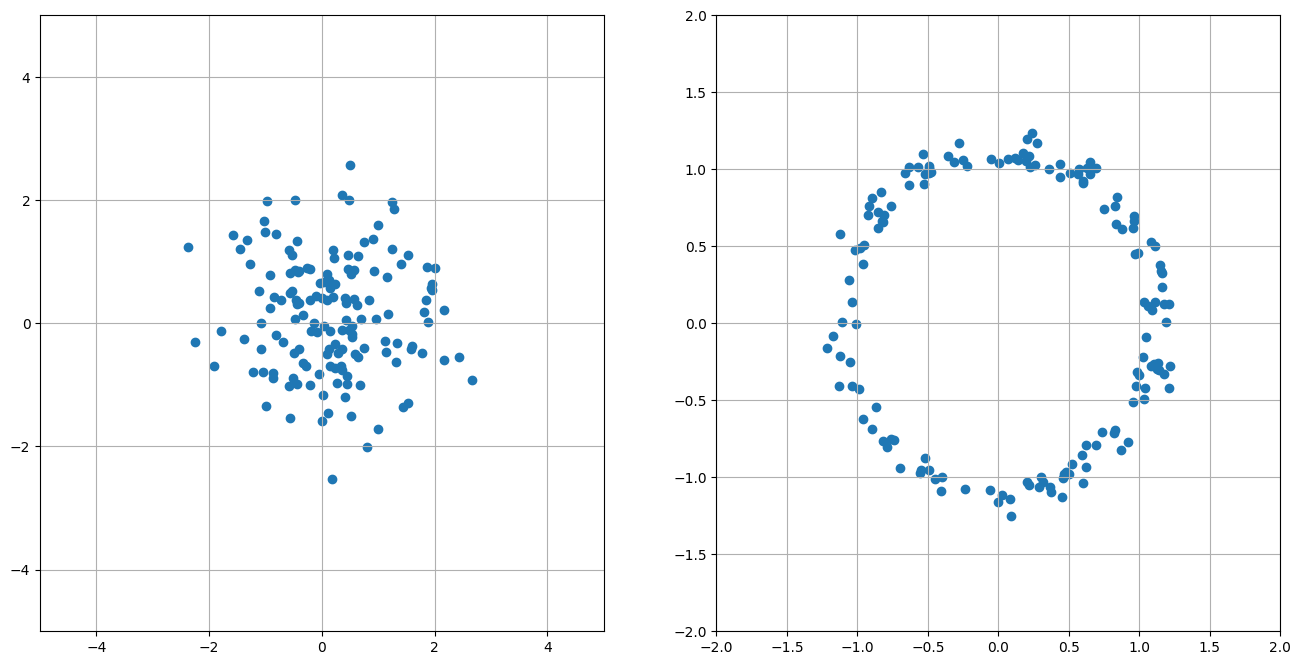

In [2]:
Z = np.random.randn(150, 2)
X = Z/(np.sqrt(np.sum(Z*Z, axis=1))[:, None]) + Z/10

fig, axs = plt.subplots(1, 2, sharex=False, figsize=(16,8))

ax = axs[0]
ax.scatter(Z[:,0], Z[:,1])
ax.grid(True)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)

ax = axs[1]
ax.scatter(X[:,0], X[:,1])
ax.grid(True)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

Пример выше из ***[1]***

Таким образом, если подобрать правильные функции, то можно отобразить пространства скрытых переменных обычных автоэнкодеров в какие-то хорошие пространства, например такие, где распределение нормально. А потом обратно.

С другой стороны специально учиться отображать одни скрытые пространства в другие вовсе не обязательно. Если есть какие-то полезные скрытые пространства, то правильный автоэнкодер научится им по пути сам, но отображать, в конечно итоге, будет в нужное нам пространство.

***Вариационные автоэнкодеры*** (*Variational Autoencoders*) - это автоэнкодеры, которые учатся отображать объекты в заданное скрытое пространство и, соответственно, сэмплить из него. Поэтому *вариационные автоэнкодеры* относят так же к семейству генеративных моделей.

![](pics/03_vae_vae_diagram.png)  

Иллюстрация из ***[2]***

Далее выжимка теории из ***[1]*** лежащая в основе *VAE*.

Пусть $Z$ - скрытые переменные, а $X$ - данные. 
На примере нарисованых цифр рассмотрим естесственный генеративный процесс, который сгенерировал нашу выборку:
$$
P(X) = \int_{z} P(X|Z)P(Z)dZ
$$

- $P(X)$ вероятностное распределение изображений цифр на картинках, т.е. вероятность конкретного изображения цифры впринципе быть нарисованым (если картинка не похожа на цифру, то эта вероятность крайне мала, и наоборот),
- $P(Z)$ - вероятностное распределение скрытых факторов, например, распределение толщины штриха,
- $P(X|Z)$ - распределение вероятности картинок при заданных скрытых факторах, одни и те же факторы могут привезти к разным картинкам (один и тот же человек в одних и тех же условиях не рисует абсолютно одинаковые цифры)

Представим $P(X|Z)$ как сумму некоторой генерирующей функции $f(Z)$ и некоторого сложного шума $\epsilon$

$$
P(X|Z) = f(Z) + \epsilon
$$

Мы хотим построить некоторый искусственный генеративный процесс, который будет создавать объекты близкие в некоторой метрике к тренировачным $X$.

$$
P(X;\theta) = \int_{z} P(X|Z;\theta)P(Z)dZ \ \ \ (1)
$$
и снова
$$
P(X|Z;\theta) = f(Z;\theta) + \epsilon
$$

$f(Z;\theta)$ - некоторое семейсто функций, которое представляет наша модель, а $\theta$ - ее параметры. Выбирая метрику - мы выбираем то, какого вида нам представляется шум $\epsilon$. Если метрика $L_2$, то мы считаем шум нормальным и тогда:

$$
P(X|Z;\theta) = N(X|f(Z;\theta), \sigma^2 I),
$$

По принципу максимального правдоподобия нам остается оптимизировать параметры $\theta$ для того, чтобы максимизировать $P(X)$, т.е. вероятность появления объектов из выборки.

Проблема в том, что оптимизировтаь интеграл (1) напрямую мы не можем: пространство может быть высокоразмерное, объектов много, да и метрика плохая. С другой стороны, если задуматься, то к каждому конкретному $X$ может привезти лишь очень небольшое подмножество $Z$, для остальных же $P(X|Z)$ будет очень близок к нулю. 
И при оптимизации достаточно сэмплить только из хороших $Z$.

Для того чтобы знать из каких $Z$ нам надо сэмплить, введем новое распределение $Q(Z|X)$, которое в зависимости от $X$ будет показывать распределение $Z \sim Q$, которое могло привезти к этому $X$.

Запишем сперва расстояние Кульбака-Лейблера (несимметричная мера "похожести" двух распределений, подробнее ***[3]***) между
$Q(Z|X)$ и реальным $P(Z|X)$:

$$
KL[Q(Z|X)||P(Z|X)] = \mathbb{E}_{Z \sim Q}[\log Q(Z|X) - \log P(Z|X)]
$$

Применяем формулу Байеса:

$$
KL[Q(Z|X)||P(Z|X)] = \mathbb{E}_{Z \sim Q}[\log Q(Z|X) - \log P(X|Z) - \log P(Z)] + \log P(X)
$$

Выделяем еще одно расстояние Кульбака-Лейблера:

$$
KL[Q(Z|X)||P(Z|X)] = KL[Q(Z|X)||\log P(Z)] - \mathbb{E}_{Z \sim Q}[\log P(X|Z)] + \log P(X)
$$

В итоге получаем тождество:

$$
\log P(X) - KL[Q(Z|X)||P(Z|X)] = \mathbb{E}_{Z \sim Q}[\log P(X|Z)] - KL[Q(Z|X)||P(Z)]
$$


Это тождество - краеугольный камень *вариационных автоэнкодеров*, оно верно для любых $Q(Z|X)$ и $P(X,Z)$.

Пусть $Q(Z|X)$ и $P(X|Z)$ зависят от параметров: $Q(Z|X;\theta_1)$ и $P(X|Z;\theta_2)$, а $P(Z)$ - нормальное $N(0,I)$, тогда получаем:

$$
\log P(X;\theta_2) - KL[Q(Z|X;\theta_1)||P(Z|X;\theta_2)] = \mathbb{E}_{Z \sim Q}[\log P(X|Z;\theta_2)] - KL[Q(Z|X;\theta_1)||N(0,I)]
$$

Взглянем повнимательнее на то, что у нас получилось:
- во-первых, $Q(Z|X;\theta_1)$, $P(X|Z;\theta_2)$ подозрительно похожи на энкодер и декодер (точнее декодер это $f$ в выражении $P(X|Z;\theta_2) = f(Z;\theta_2) + \epsilon$)
- слева в тождестве - значение, которое мы хотим максимизировать для элементов нашей тренировачной выборки $X$ + некоторая ошибка $KL$ ($KL(x,y) \ge 0 \ \ \forall x,y$), которая, будем надеяться, при достаточной емкости $Q$ уйдет в 0,
- справа значение, которое мы можем оптимизировать градиентным спуском, где первый член имеет смысл качества предсказания $X$ декодером по значениям $Z$, а второй член, это расстояние К-Л между распределением $Z \sim Q$, которое предсказывает энкодер для конкретного $X$, и распределением $Z$ для всех $X$ сразу

Для того, чтобы иметь возможность оптимизировать правую часть градиентным спуском, осталось разобраться с двумя вещами:
#### 1. Точнее определим что такое $Q(Z|X;\theta_1)$
Обычно $Q$ выбирается нормальным распределением:

$$
Q(Z|X;\theta_1) = N(\mu(X;\theta_1), \Sigma(X;\theta_1))
$$
То есть энкодер для каждого $X$ предсказывает 2 значения: среднее $\mu$ и вариацию $\Sigma$ нормального распределения, из которого уже сэмплируются значения. Работает это все примерно вот так:   
![](pics/03_vae_encoder_vae_diagram.png)  
Иллюстрация из ***[2]***


При том, что для каждой отдельной точки данных $X$ энкодер предсказывает некоторое нормальное распределение $P(Z|X) = N(\mu(X), \Sigma(X))$, для априорного распределения $Х$: $P(Z) = N(0, I)$, что получается из формулы, и это потрясающе.  
![](pics/03_vae_kl_divergence_diagram.png)  
Иллюстрация из ***[2]***


При этом $KL[Q(Z|X;\theta_1)||N(0,I)]$ принимает вид:  

$$
KL[Q(Z|X;\theta_1)||N(0,I)] = \frac{1}{2}\left(tr(\Sigma(X)) + \mu(X)^T\mu(X) - k - \log \det \Sigma(X) \right)
$$

#### 2. Разберемся с тем, как распространять ошибки через $\mathbb{E}_{Z \sim Q}[\log P(X|Z;\theta_2)]$
Дело в том, что здесь мы берем случайные значения $Z \sim Q(Z|X;\theta_1)$ и передаем их в декодер.
Ясно, что распросранять ошибки через случайные значения напрямую нельзя, поэтому используется так называемый *трюк с репараметризацией* (*reparametrization trick*).

Схема получается вот такая:  
![](pics/03_vae_reparam_trick.png)  
Иллюстрация из ***[1]***

Здесь на левой картинке схема без трюка, а на правой с трюком.
Красным цветом показано семплирование, а синим вычисление ошибки.  
То есть по сути просто берем предсказанное энкодером стандартное отклонение $\Sigma$ умножаем на случайное число из $N(0,I)$ и добавляем предсказанное среднее $\mu$.

Прямое растространение на обеих схемах абсолютно одинаковое, однако на правой схеме работает обратное распространение ошибки.

После того, как мы обучили такой вариационный автоэнкодер, декодер становится полноправной генеративной моделью. По сути и энкодер то нужен в основном для того, чтобы обучить декодер отдельно быть генеративной моделью.  
![](pics/03_vae_vae_decoder_diagram.png)  
Иллюстрация из ***[2]***  
<img src="./pics/03_vae_generator.png" width="300"/>  
Иллюстрация из ***[1]***  

Но то, что энкодер и декодер вместо образуют еще и полноценный автоэнкодер, это очень приятный плюс.

# VAE в Keras 

Теперь, когда мы разобрались в том, что такое вариационные автоэнкодеры, напишем такой на *Keras*

Зададим основные параметры. Скрытое пространство возьмем размерности 2, чтобы позже генерировать из него и визуализировать результат.  
***Замечание***: размерность 2 крайне мала, особенно в метрике $L_2$, поэтому следует ожидать, что цифры получатся очень размытыми.

In [3]:
batch_size = 256
latent_dim = 2
dropout_rate = 0.3
start_lr = 0.0001

In [4]:
x_train, y_train, x_test, y_test = get_mnist()

Напишем модели вариационного автоэнкодера. 

Для того, чтобы обучение происходило быстрее и более качественно, добавим слои *dropout* и *batch normalization*.
А в декодере используем в качестве активации *leaky ReLU*, которую добавляем отдельным слоем после *dense* слоев без активации.

Функция *sampling* реализует сэмплирование значений $Z$ из $Q(X)$ с использованием трюка репараметризации.

*vae_loss* это правая часть из уравнения:

$$
\log P(X;\theta_2) - KL[Q(Z|X;\theta_1)||P(Z|X;\theta_2)] = \mathbb{E}_{Z \sim Q}[\log P(X|Z;\theta_2)] - \left(\frac{1}{2}\left(tr(\Sigma(X)) + \mu(X)^T\mu(X) - k - \log \det \Sigma(X) \right)\right)
$$

далее будет использоваться в качестве лосса.

In [5]:
def create_vae():
    models = {}

    # Добавим Dropout и BatchNormalization
    def apply_bn_and_dropout(x):
        return Dropout(dropout_rate)(BatchNormalization()(x))

    # Энкодер
    input_img = Input(batch_shape=(batch_size, 28, 28, 1))
    x = Flatten()(input_img)
    x = Dense(256, activation='relu')(x)
    x = apply_bn_and_dropout(x)
    x = Dense(128, activation='relu')(x)
    x = apply_bn_and_dropout(x)

    # Предсказываем параметры распределений
    # Вместо того, чтобы предсказывать стандартное отклонение, предсказываем логарифм вариации
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)

    # Сэмплирование из Q с трюком репараметризации
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        return z_mean + K.exp(z_log_var / 2) * epsilon
        
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    models["encoder"]  = Model(input_img, l, name = 'Encoder') 
    models["z_meaner"] = Model(input_img, z_mean, name = 'Enc_z_mean')
    models["z_lvarer"] = Model(input_img, z_log_var, name = 'Enc_z_log_var')

    # Декодер
    z = Input(shape=(latent_dim, ))
    # x = Dense(128, activation=leaky_relu)(z)
    x = Dense(128)(z)
    x = LeakyReLU()(x)
    x = apply_bn_and_dropout(x)
    # x = Dense(256, activation=leaky_relu)(x)
    x = Dense(256)(x)
    x = LeakyReLU()(x)
    x = apply_bn_and_dropout(x)
    x = Dense(28*28, activation='sigmoid')(x)
    decoded = Reshape((28, 28, 1))(x)

    models["decoder"] = Model(z, decoded, name='Decoder')
    models["vae"]     = Model(input_img, models["decoder"](models["encoder"](input_img)), name="VAE")

    def vae_loss(x, decoded):
        # print(x.shape, decoded.shape)
        x = K.reshape(x, shape=(batch_size, 28*28))
        decoded = K.reshape(decoded, shape=(batch_size, 28*28))
        # print(x.shape, decoded.shape)
        bce = BinaryCrossentropy(from_logits=True)
        print(type(bce(x, decoded)),bce(x, decoded))
        # bce(x, decoded).numpy()
        # xent_loss = 28 * 28 * bce(x, decoded).numpy()

        xent_loss = 28 * 28 * binary_crossentropy(x, decoded)
        # print(xent_loss)
        
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        
        print((xent_loss + kl_loss)/2/28/28)

        return (xent_loss + kl_loss)/2/28/28

    return models, vae_loss
    # return models

# models = create_vae()
models, vae_loss = create_vae()
# vae = models["vae"]

In [12]:
# from tensorflow.keras.utils import plot_model
# from keras.utils import plot_model
# from tf.keras.utils import plot_model

vae = models["vae"]
vae.compile(optimizer=Adam(start_lr), loss=vae_loss, run_eagerly=True) #, experimental_run_tf_function=False)



tf.keras.utils.plot_model(vae)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [18]:
vae = models["vae"]
vae.compile(optimizer=Adam(start_lr), loss=vae_loss, run_eagerly=True) #, experimental_run_tf_function=False)

vae.fit(x_train, x_train, shuffle=True, epochs=2,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        # callbacks=[pltfig, tb],
        # verbose=1
        )

Epoch 1/2
<class 'tensorflow.python.framework.ops.EagerTensor'> tf.Tensor(0.9116002, shape=(), dtype=float32)
KerasTensor(type_spec=TensorSpec(shape=(256,), dtype=tf.float32, name=None), name='tf.math.truediv_14/truediv:0', description="created by layer 'tf.math.truediv_14'")


TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='Placeholder:0', description="created by layer 'tf.cast_14'"), an intermediate Keras symbolic input/output, to a TF API that does not allow registering custom dispatchers, such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. Keras Functional model construction only supports TF API calls that *do* support dispatching, such as `tf.math.add` or `tf.reshape`. Other APIs cannot be called directly on symbolic Kerasinputs/outputs. You can work around this limitation by putting the operation in a custom Keras layer `call` and calling that layer on this symbolic input/output.

In [9]:
# vae.compile(optimizer=Adam(start_lr), loss=vae_loss, run_eagerly=True) #, experimental_run_tf_function=False)

# Сохраним в формате h5
# vae.save("../models/03_vae_01.h5", save_format="h5")

# Посмотрим на число параметров
# vae.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(500, 28, 28, 1)]        0         
                                                                 
 Encoder (Functional)        (500, 2)                  235908    
                                                                 
 Decoder (Functional)        (None, 28, 28, 1)         236432    
                                                                 
Total params: 472,340
Trainable params: 470,804
Non-trainable params: 1,536
_________________________________________________________________


In [10]:
# Запуск обучения 
vae.fit(x_train, x_train, shuffle=True, epochs=2,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        # callbacks=[pltfig, tb],
        # verbose=1
        )

Epoch 1/2


TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='Placeholder:0', description="created by layer 'tf.cast_2'"), an intermediate Keras symbolic input/output, to a TF API that does not allow registering custom dispatchers, such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. Keras Functional model construction only supports TF API calls that *do* support dispatching, such as `tf.math.add` or `tf.reshape`. Other APIs cannot be called directly on symbolic Kerasinputs/outputs. You can work around this limitation by putting the operation in a custom Keras layer `call` and calling that layer on this symbolic input/output.

In [41]:
# from keras.losses import BinaryCrossentropy as bki
# from keras.metrics import BinaryCrossentropy as bkim


# <class 'tensorflow.python.framework.ops.Tensor'> Tensor("loss_1/Decoder_loss/binary_crossentropy_1/weighted_loss/value:0", shape=(), dtype=float32)

In [10]:
# bki([1],[0.9]).numpy() #, bkim([1],[0.9])

y_true = [[0., 1., 0., 0.],[0., 1., 0., 0.]]
y_pred = [[-18.6, 0.51, 2.94, -12.8],[-18.6, 0.51, 2.94, -12.8]]
bce = BinaryCrossentropy(from_logits=True)
# bce = binary_crossentropy(from_logits=True)
# bce(y_true, y_pred).numpy()
print(type(bce(y_true, y_pred)), bce(y_true, y_pred))

print(type(binary_crossentropy(y_true, y_pred)), binary_crossentropy(y_true, y_pred))

# <class 'tensorflow.python.framework.ops.Tensor'> Tensor("binary_crossentropy_2/weighted_loss/value:0", shape=(), dtype=float32)


<class 'tensorflow.python.framework.ops.EagerTensor'> tf.Tensor(0.865458, shape=(), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'> tf.Tensor([4.0016456 4.0016456], shape=(2,), dtype=float32)


In [ ]:
tensorflow.python.framework.ops.EagerTensor
<tf.Tensor: shape=(), dtype=float32, numpy=0.865458>

<class 'tensorflow.python.framework.ops.Tensor'> Tensor("vae_loss/binary_crossentropy_1/weighted_loss/value:0", shape=(), dtype=float32)